In [ ]:
# one-hot encoder

import numpy as np
from collections import defaultdict

def encode_one_hot(train_set, classes="AGCT"):
    encoder = defaultdict(lambda: np.array([0]*len(classes)))
    pad = 9
        
    for i, _class in enumerate(classes):
        tmp = np.zeros(len(classes))
        tmp[i] = 1
        encoder[_class] = tmp
        
    output = []
    for record in tqdm(train_set):
        encoded_record = []
        for i in range(pad):
            encoded_record.append([.25, .25, .25, .25])
        for c in record.upper():
            encoded_record.append(encoder[c])
        for i in range(pad):
            encoded_record.append([.25, .25, .25, .25])
            
        output.append(encoded_record)
        
    output = np.array(output)
    
    return output

In [ ]:
# Parsing
import gzip
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from google.colab import files

def get_dataset(path):
    
    dataset =  gzip.open(path, "r")
    output = []    
    for i, record in tqdm(enumerate(dataset)):
        record = record.decode()
        record = record[:-1]
        record = record.split('\t')
        if i != 0:
            output.append(record)
    output = np.array(output).reshape([-1, 4])
    
    return encode_one_hot(output[:, 2]), np.array([int(i) for i in output[:, 3]]).flatten()

x1, y1 = get_dataset("")
x2, y2 = get_dataset("")
x = np.append(x1, x2, axis=0)
y = np.append(y1, y2, axis=0)

In [ ]:
train_x, temp_x, train_y, temp_y = train_test_split(x, y, test_size = 0.4, random_state=112)
valid_x, test_x, valid_y, test_y = train_test_split(temp_x, temp_y, test_size = 0.5, random_state=112)

del(y)
del(temp_x, temp_y)

print(train_x.shape)
print(train_y.shape)

print(valid_x.shape)
print(valid_y.shape)

print(test_x.shape)
print(test_y.shape)

128013it [00:00, 168015.97it/s]
100%|██████████| 128012/128012 [00:02<00:00, 47142.37it/s]
255509it [00:01, 169119.80it/s]
100%|██████████| 255508/255508 [00:05<00:00, 45989.94it/s]


(230112, 38, 4)
(230112,)
(76704, 38, 4)
(76704,)
(76704, 38, 4)
(76704,)


In [ ]:
# train
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Conv1D, ReLU, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy
from tensorflow.keras import backend as K

K.clear_session()
epoch = 10
l2_rate = 1e-5
lr = 0.001
batch_size = 32

model = Sequential()
#Conv
model.add(Conv1D(input_shape=train_x.shape[1:], 
                 filters=16, kernel_size=10, strides=1, 
                 kernel_regularizer=regularizers.l2(l2_rate)))
#Relu 활성함수
model.add(ReLU())
#Pooling
model.add(MaxPooling1D(pool_size=29))
model.add(Flatten())
#MLP
model.add(Dense(32, kernel_regularizer=regularizers.l2(l2_rate)))
model.add(ReLU())
# 드롭
model.add(Dropout(rate=0.3))
# Softmax 정규화
model.add(Dense(1, activation = 'sigmoid', kernel_regularizer=regularizers.l2(l2_rate)))

adam = Adam(lr=lr)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[AUC(),'accuracy', Precision(), Recall()])
model.summary()

In [ ]:
history = model.fit(train_x, train_y, 
                    validation_data=(valid_x, valid_y), 
                    batch_size=batch_size, epochs=epoch, shuffle=True, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 16)            656       
_________________________________________________________________
re_lu (ReLU)                 (None, 29, 16)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

In [ ]:
result = model.evaluate(test_x, test_y, batch_size=32)

2397/2397 [==============================] - 13s 5ms/step - loss: 0.2057 - auc: 0.9707 - accuracy: 0.9170 - precision: 0.9277 - recall: 0.9495


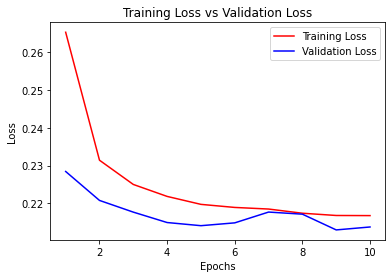

In [ ]:
# graph
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()